In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.style as style
import seaborn as sns
# Jupyter Notebookのマジックコマンドは削除し、必要に応じて設定を調整
plt.style.use('default')  # ggplotやfivethirtyeightなど他のスタイルを使用できます
sns.set()  # seabornのスタイルを使用

# データの読み込み
df = pd.read_csv('criteo-uplift-v2.1.csv')

In [6]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [52]:
from sklearn.model_selection import train_test_split

X = df.drop(['treatment', 'exposure', 'visit', 'conversion'], axis=1)
X = (X - X.mean()) / X.std()
T = df['treatment']
y_r = df["conversion"]
y_c = df["visit"]

X_train, X_test, T_train, T_test, y_r_train, y_r_test, y_c_train, y_c_test = train_test_split(
    X, T, y_r, y_c, train_size=0.7, random_state=42, stratify=T
)

# インデックスをリセット
T_test = T_test.reset_index(drop=True)
y_r_test = y_r_test.reset_index(drop=True)
y_c_test = y_c_test.reset_index(drop=True)

In [126]:
import lightgbm as lgb
def custom_objective(y_pred: np.ndarray, train_data: lgb.Dataset):
    y_r = y_r_train
    y_c = y_c_train
    t = T_train.values
    treatment = (t == 1)
    control = (t == 0)

    N_1 = np.sum(treatment)
    N_0 = np.sum(control)

    p = 1 / (1 + np.exp(-y_pred))

    grad = ((-1) ** t) * (y_r - y_c * p) / np.where(treatment, N_1, N_0)

    hess = abs(((-1) ** (t + 1))) * y_c * p * (1 - p) / np.where(treatment, N_1, N_0)

    return grad, hess

def get_roi_direct():
    dtrain = lgb.Dataset(X_train, free_raw_data=False)

    params = {
        'objective': lambda y_pred, train_data: custom_objective(y_pred, train_data),
        'verbose': -1,
    }
    bst = lgb.train(params, dtrain)
    roi_direct = bst.predict(X_test, num_iteration=bst.best_iteration)
    return roi_direct


In [127]:
roi_direct = get_roi_direct()

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

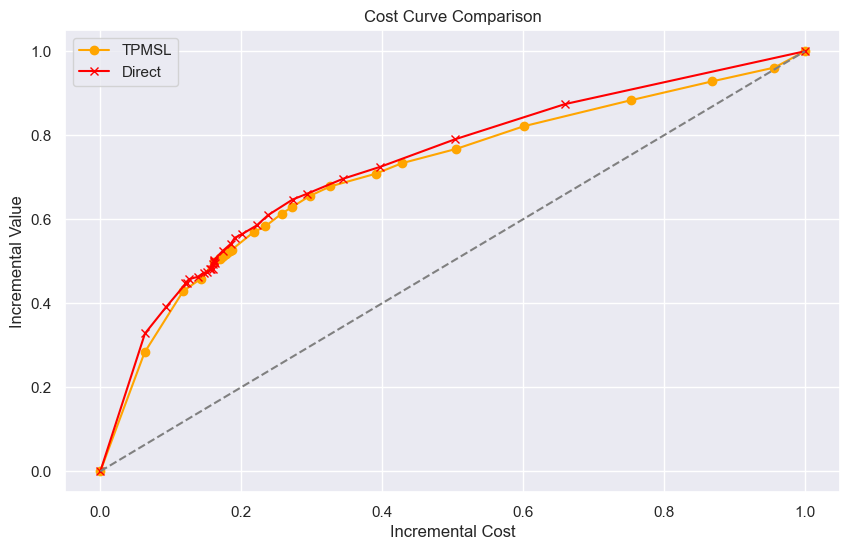

In [128]:
def calculate_values(roi_scores):
    sorted_indices = np.argsort(roi_scores)[::-1]
    p_values = np.linspace(0, 1, 30)
    incremental_costs = []
    incremental_values = []
    
    for p in p_values:
        top_p_indices = sorted_indices[:int(p * len(roi_scores))]
        treatment_indices = (T_test[top_p_indices] == 1)
        
        # ATE (Average Treatment Effect) の計算
        ATE_Yr = np.mean(y_r_test[top_p_indices][treatment_indices]) - np.mean(y_r_test[top_p_indices][~treatment_indices])
        ATE_Yc = np.mean(y_c_test[top_p_indices][treatment_indices]) - np.mean(y_c_test[top_p_indices][~treatment_indices])
        
        incremental_costs.append(ATE_Yc * np.sum(treatment_indices))
        incremental_values.append(ATE_Yr * np.sum(treatment_indices))
        # print(ATE_Yr , ATE_Yc,np.sum(treatment_indices))
        incremental_costs[0] = 0
        incremental_values[0] = 0
        
    return incremental_costs, incremental_values

incremental_costs_tpmsl, incremental_values_tpmsl = calculate_values(roi_tpmsl)
incremental_costs_direct, incremental_values_direct = calculate_values(roi_direct)


# 横軸と縦軸を正規化してグラフ描画
plt.figure(figsize=(10, 6))
plt.plot(incremental_costs_tpmsl / max(incremental_costs_tpmsl), incremental_values_tpmsl / max(incremental_values_tpmsl), marker='o', color='orange',  label='TPMSL')
plt.plot(incremental_costs_direct / max(incremental_costs_direct), incremental_values_direct / max(incremental_values_direct), marker='x', color='red', label='Direct')
# y = x の直線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Cost Curve Comparison')
plt.xlabel('Incremental Cost')
plt.ylabel('Incremental Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def get_roi_tpmsl():
    # 必要なライブラリのインポート
    from sklearn.ensemble import RandomForestRegressor
    from econml.metalearners import SLearner
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import MinMaxScaler
    from lightgbm import LGBMRegressor


    # モデルの構築
    models = LGBMRegressor()
    # models = LinearRegression()
    S_learner_r = SLearner(overall_model = models)
    S_learner_r.fit(y_r_train, T_train, X = X_train)

    S_learner_c = SLearner(overall_model = models)
    S_learner_c.fit(y_c_train, T_train, X = X_train)

    # 効果の推定
    tau_r = S_learner_r.effect(X_test)
    tau_c = S_learner_c.effect(X_test)
    roi_tpmsl = tau_r / tau_c

    scaler = MinMaxScaler()
    roi_tpmsl = scaler.fit_transform(roi_tpmsl.reshape(-1, 1)).flatten()

    # roi_tpmsl = sigmoid(roi_tpmsl)
    return roi_tpmsl

roi_tpmsl = get_roi_tpmsl()

## Cost Aware Assignment Problem

48929it [01:06, 736.09it/s]


Epoch 0, Average Loss: 1.7953929360070104


48929it [01:05, 744.17it/s]
48929it [01:05, 744.66it/s]
48929it [01:05, 742.47it/s]
48929it [01:05, 745.24it/s]
48929it [01:05, 744.48it/s]
48929it [01:05, 743.85it/s]
48929it [01:05, 742.73it/s]
48929it [01:05, 744.16it/s]
48929it [01:05, 744.45it/s]
48929it [01:05, 743.55it/s]


Epoch 10, Average Loss: 1.72200257094287


48929it [01:05, 744.65it/s]
48929it [01:05, 744.49it/s]
48929it [01:05, 744.68it/s]
48929it [01:05, 744.91it/s]
48929it [01:05, 743.17it/s]
48929it [01:05, 742.11it/s]
48929it [01:06, 737.67it/s]
48929it [01:06, 739.17it/s]
48929it [01:05, 750.57it/s]
48929it [01:05, 751.55it/s]


Epoch 20, Average Loss: 1.7216739752894343


48929it [01:05, 751.34it/s]
48929it [01:05, 751.78it/s]
48929it [01:05, 751.94it/s]
48929it [01:05, 752.10it/s]
48929it [01:05, 747.99it/s]
48929it [01:06, 740.53it/s]
48929it [01:06, 740.59it/s]
48929it [01:06, 739.37it/s]
48929it [01:05, 746.76it/s]


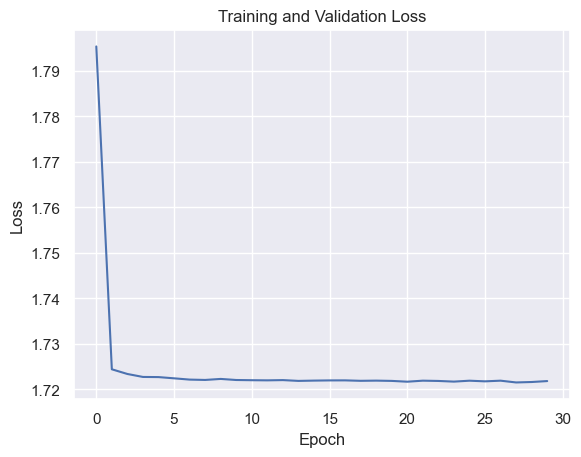

In [13]:
import matplotlib.pyplot as plt
import cost_aware

model, loss_history = cost_aware.get_loss(num_epochs=30)
roi_direct = cost_aware.get_roi(model)

# 損失の可視化
plt.plot(loss_history)
# plt.plot(loss_history_val)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### TPM-SL

In [7]:
roi_tpmsl = cost_aware.get_roi_tpmsl()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.002913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.046992


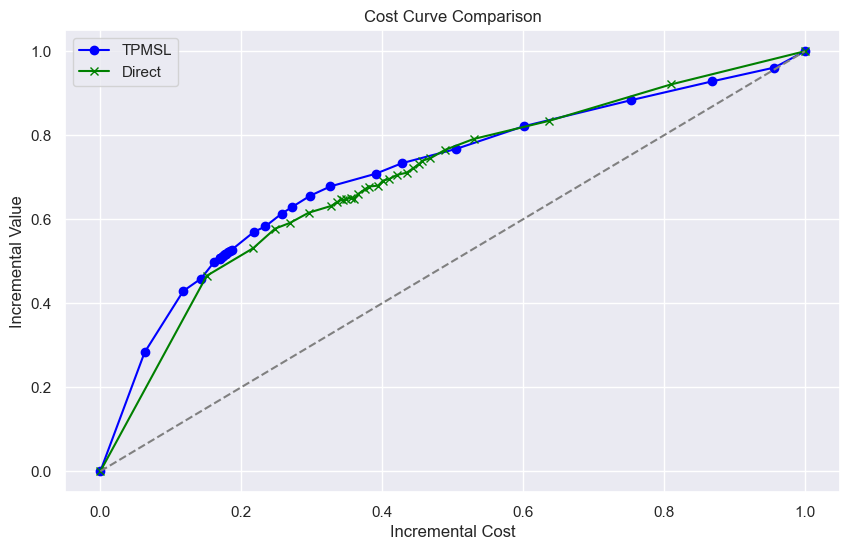

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# 処理を関数化して同じ処理を二回行う

# それぞれのデータセットについて計算
incremental_costs_tpmsl, incremental_values_tpmsl = cost_aware.calculate_values(roi_tpmsl)
incremental_costs_direct, incremental_values_direct = cost_aware.calculate_values(roi_direct)


# 横軸と縦軸を正規化してグラフ描画
plt.figure(figsize=(10, 6))
plt.plot(incremental_costs_tpmsl / max(incremental_costs_tpmsl), incremental_values_tpmsl / max(incremental_values_tpmsl), marker='o', color='blue',  label='TPMSL')
plt.plot(incremental_costs_direct / max(incremental_costs_direct), incremental_values_direct / max(incremental_values_direct), marker='x', color='green', label='Direct')
# y = x の直線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Cost Curve Comparison')
plt.xlabel('Incremental Cost')
plt.ylabel('Incremental Value')
plt.legend()
plt.grid(True)
plt.show()

## Cost Unaware Treament Assignment Problem

In [2]:
import cost_unaware
tau_direct = cost_unaware.get_tau_direct()
tau_sl = cost_unaware.get_tau_sl()
tau_xl = cost_unaware.get_tau_xl()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.046992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 1467856, number of used features: 12
[LightGBM] [Info] Start training from score 0.038205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

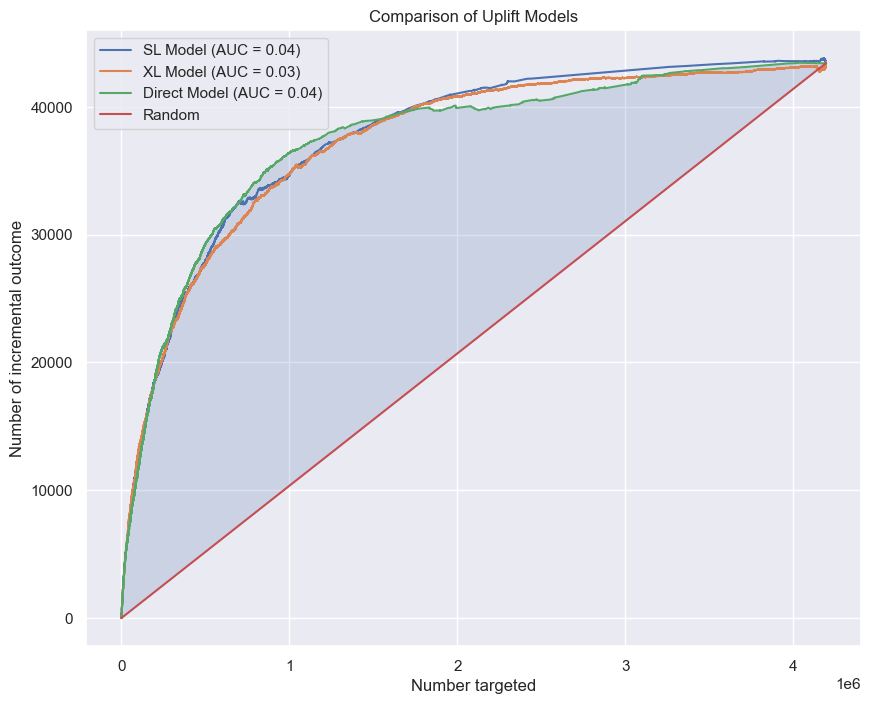

In [4]:
import cost_unaware
import numpy as np
cost_unaware.uplift(tau_sl, tau_xl, tau_direct)

### Causal Forest

In [16]:
# # causal forest での効果の推定
# from econml.dml import CausalForestDML
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from statsmodels.nonparametric.kernel_regression import KernelReg

# # モデルの構築
# cf = CausalForestDML(model_y=LinearRegression(),
#                      model_t=LogisticRegression(),
#                      discrete_treatment=True,
#                      n_estimators=4)
# cf.fit(y_train, T_train, X=X_train)

# # 効果の推定
# tau_cf = cf.effect(X_test)